DeGAN neural network with generative extra training.

#### Loading libs

In [3]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout, Lambda
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new!
from keras import backend as K
from keras.utils.vis_utils import plot_model
# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### This code uses once per colab session to download *pydot* and *graphviz* libs

In [ ]:
!pip3 install pydotplus
!pip3 install pydot
!apt-get -qq install -y graphviz && pip3 install -q pydot
!pip3 install pydot-ng
!pip3 install graphviz
!apt-get install python-pydot python-pydot-ng graphviz
import pydot

#### IN COLAB Load data from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')
input_images = "/content/drive/My Drive/full_numpy_bitmap_castle.npy"
data = np.load(input_images)

#### LOCALLY Loading data

In [5]:
input_images = "D:/full_numpy_bitmap_castle.npy"
data = np.load(input_images)

#### Some input data tests

In [7]:
data.shape #output amount of pics and dimensions

(122534, 784)

In [8]:
data[3117] #output pic 3117

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,  13,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 106, 179,  95,
        16,  33, 208,  50, 199, 229, 250, 255,  98,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  11, 238,
       244, 255, 232,  87, 255, 119, 255, 174, 139, 255, 104,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

#### Normalizing data and reshape into square pic


In [9]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]

#### Some reshaped data tests

In [ ]:
data.shape #output amount of pics and dimensions

In [ ]:
data[3117] #output pic 3117

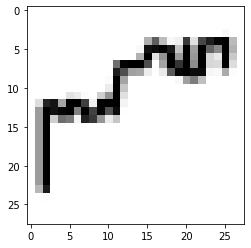

In [11]:
plt.imshow(data[3117,:,:,0], cmap='Greys') #output bitmap as a picture

#### Create network of discriminator function
*depth* - base neurons amount in hidden layer

*p* - dropout coefficient

return discriminator network model

In [12]:
def build_discriminator(depth=64, p=0.4):

    # input layer
    image = Input((img_w,img_h,1))
    
    # Hide layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid', name='prediction')(conv4)
    
    # Model construction
    model = Model(inputs=image, outputs=prediction)

    # printing summary info about discriminator
    print(model.summary())
    plot_model(model, to_file='discriminator_model_plot.png', show_shapes=True, show_layer_names=True)

    return model

#### Compiling discriminator model

In [13]:
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=RMSprop(lr=0.0008,
                                        decay=6e-8,
                                        clipvalue=1.0),
                      metrics=['binary_accuracy'])

#### Build an untrainable discriminator
Full copy of trainable discriminator, for avoiding unfixed error in Keras.

In [16]:
# Build second discriminator:
discriminator_ = build_discriminator()

# Deny training of this discriminator
discriminator_.trainable = False

# Copying actual parameters into frozen discriminator
def copy_weights(source, target):
    for i, layer in enumerate(source.layers):
        target.layers[i].set_weights(source.layers[i].get_weights())

#### Create generator network

In [18]:
z_dimensions = 32 #input noise signal dimensions amount

#### Define generator network function
*latent_dim* - input dimensions

*depth* - base neurons amount in hidden layer

*p* - dropout coefficient

return generator network model

In [19]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Inputs
    noise = Input((latent_dim,))
    
    # Input preparation and reshaping
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # Deconvolutional layers with batch normalisation
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model construction
    model = Model(inputs=noise, outputs=image)

    # printing summary info about generator
    print(model.summary())
    plot_model(model, to_file='generator_model_plot1.png', show_shapes=True, show_layer_names=True)

    return model

#### Compiling generator model

In [20]:
generator = build_generator()
generator.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004,
                                            decay=3e-8,
                                            clipvalue=1.0),
                          metrics=['accuracy'])

#### Building adversarial network function
*no parameters*

return adversarial network model

In [23]:
def build_adversarial():
          
    # Input
    z = Input(shape=(z_dimensions,))
    
    # Generate input noise vector
    img = generator(z)
    
    # Make prediction
    pred = discriminator_(img)
       
    # Build model
    model = Model(inputs=z, outputs=pred)

    # printing summary info about whole adversarial network
    print(model.summary())
    plot_model(model, to_file='adv_model_plot1.png', show_shapes=True, show_layer_names=True)

    return model

#### Build adversarial network

In [24]:
adversarial_model = build_adversarial()
adversarial_model.compile(loss='binary_crossentropy',
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Training function
*epoch* - number of epoch

*batch* - number of pics into one training batch

*z_dim* - number of input noise signal dimensions

return adversarial network metrics, discriminator metrics

In [27]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # train discriminator
        # ________________________________________
        # real pics with randomisation:
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake pics:
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate real and fake pics:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator:
        y = np.ones([2*batch,1]) - np.random.uniform(0,0.1,[2*batch,1])
        y[batch:,:] = 0
        y[batch:,:] += np.random.uniform(0,0.1,[batch,1])
        
        # make training
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        

        # train adversarial network
        # ________________________________________
        
        # noise input
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # Copy weights to second discriminator
        copy_weights(discriminator, discriminator_)
        
        # make train
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]

        #     Results     #
        # ________________________________________
        
        # periodically print progress and fake images:
        if (i+1)%20 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

#### Start training procedure

In [28]:
a_metrics_complete, d_metrics_complete = train()

KeyboardInterrupt: 

#### Print Loss and Accuracy plots

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

In [ ]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")